<a href="https://colab.research.google.com/github/Nishan-Charlie/e17-4yp-Applying-deep-learning-on-histological-images-of-lymph-tissues/blob/main/efficient_net_new_HE_from_IHC_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# System
import time
import os, platform, sys
import copy
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [ ]:
num_epochs = 15                   # Number of training epochs
dataset_dir = "./data_color/"  # quick train in "_data/faces", complete training data in "_data/faces_google"

step = 0.0004                       # Learning rate -----need to check
batch_size = 32                     # Number of samples for each training step
gamma_lr_scheduler = 0.1            # Learning rate reduction applied every 10 epochs.
rng_seed = 3                        # Seed for random number generator
start_time = time.time()            # Start of the computation timer

model_fileext = ".pth"
log_fileext = ".log"

In [ ]:
# USE NVidia CUDA (GPU) if available
# ----------------------------------
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
if is_cuda_available:
    print ("cuda is available, using:", device)
else:
    print ("cuda is not available, using:", device)

cuda is available, using: cuda:0


In [ ]:
# initialize data loaders
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
}

data_dir = dataset_dir # Images data, faces with and without mask
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

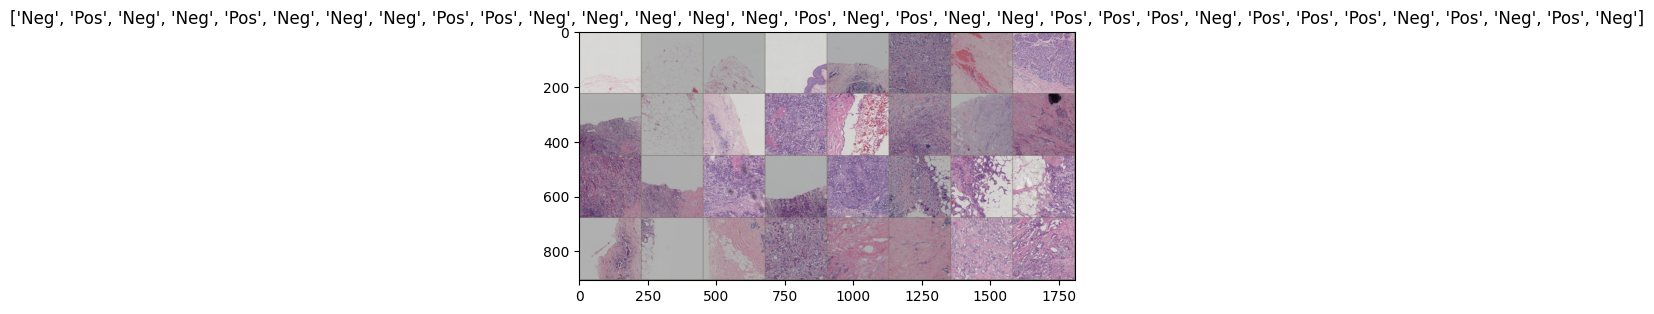

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_hybrid = torch.load('efficient_b0_on_ihc.pt')
#for param in model_hybrid.parameters():
#    param.requires_grad = False

model_hybrid = model_hybrid.to(device)
model_hybrid

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    message = "  => Training Started."
    #myprint(log_filename, "append", message, screen=True)

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                message = "     > Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                                    phase,
                                    epoch + 1,
                                    num_epochs,
                                    it + 1,
                                    n_batches + 1,
                                    time.time() - since_batch,
                                 )
                # Print to file (not to screen)
                #myprint(log_filename, "append", message, screen=False)
                # Print to screen with flush=True
                print(message,
                        end="\r",
                        flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            message = "     > Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                                "train" if phase == "train" else "validation  ",
                                epoch + 1,
                                num_epochs,
                                epoch_loss,
                                epoch_acc,
                            )
           # myprint(log_filename, "append", message, screen=True)

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            train_Acc = "{:.4f}".format(best_acc_train)
            train_Loss = "{:.4f}".format(best_loss_train)
            val_Acc = "{:.4f}".format(best_acc)
            val_Loss = "{:.4f}".format(best_loss)

            # Update learning rate
            if phase == "train":
                scheduler.step()

        # save the retrained model at this epoch completion
        # epoch is saved as epoch+1 (so to start at 1 instead of 0)
        # ---------------------------------------------------------


        # save results of trained model at this epoch
        # -------------------------------------------
        # append list of "epoch, train accuracy, train loss, val accuracy, val loss" per epoch completion
        #   accumulate in train_val_results
        if epoch==0:
            # create first row
            train_val_results = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
            #myprint(log_filename, "append", str(train_val_results), screen=True)
        else:
            train_result_at_epoch = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
            # append new row
            train_val_results = np.append(train_val_results, train_result_at_epoch, axis=0)
            #myprint(log_filename, "append", str(train_result_at_epoch), screen=True)


    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    message = "  => Training completed in " + total_training_time
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    #myprint(log_filename, "append", message, screen=True)
    message = "  => Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc)
    #myprint(log_filename, "append", message, screen=True)
    return model, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results

In [ ]:
message = "* (START re-training the Quantum Layer)"
print(message)

# model_hybrid, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss = train_model(
#     model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs, temp_model_name = interim_model_name
# )
model_hybrid, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)
message = "* (FINISH re-training the Quantum Layer)."
print(message)


* (START re-training the Quantum Layer)
* (FINISH re-training the Quantum Layer).r: 9/9 Batch time: 0.0671


In [ ]:
test_loader = dataloaders["validation"]

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    test_running_corrects = 0.0
    test_total = 0.0
    model_hybrid.eval()
    for i, (test_inputs, test_labels) in enumerate(test_loader, 0):
        test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()

        test_outputs = model_hybrid(test_inputs)
        _, test_outputs = torch.max(test_outputs, 1)

        test_total += test_labels.size(0)
        test_running_corrects += (test_outputs == test_labels).sum().item()

        for t, p in zip(test_labels.view(-1), test_outputs.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]
precision = TP / ( TP + FP)
pre = "{:.4f}".format(precision)
print(f'Precision: {precision: .3f}')
recall = TP / (TP + FN)
rec = "{:.4f}".format(recall)
print(f'Recall (Sensitivity): {recall: .3f}')
specificity = TN / (TN + FP)
spec = "{:.4f}".format(specificity)
print(f'Specificity: {specificity: .3f}')
f1_score = 2 * (precision * recall) / (precision + recall)
f1_s = "{:.4f}".format(f1_score)
print(f'F1 Score: {f1_score: .3f}')

Precision:  0.966
Recall (Sensitivity):  0.966
Specificity:  0.963
F1 Score:  0.966


In [ ]:
# PRINT training summary
# ----------------------
from prettytable import PrettyTable

t_summary = PrettyTable()
t_summary.field_names = ["epoch", "batch size", \
    "train time", "train Acc", "train Loss", "val Acc", "val Loss", "Prec", "Recall (Sen)", "Specifi", "f1_score"]
t_summary.add_row([num_epochs, batch_size, \
    total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, pre, rec, spec, f1_s])

print(t_summary)

+-------+------------+------------+-----------+------------+---------+----------+--------+--------------+---------+----------+
| epoch | batch size | train time | train Acc | train Loss | val Acc | val Loss |  Prec  | Recall (Sen) | Specifi | f1_score |
+-------+------------+------------+-----------+------------+---------+----------+--------+--------------+---------+----------+
|   15  |     32     |  22m 12s   |   0.9953  |   0.0180   |  0.9642 |  0.1271  | 0.9655 |    0.9655    |  0.9627 |  0.9655  |
+-------+------------+------------+-----------+------------+---------+----------+--------+--------------+---------+----------+


In [ ]:
for x in train_val_results:
    print(x)

[1.         0.7421875  0.572526   0.91039427 0.25412452]
[2.         0.89427083 0.26216044 0.92114695 0.23808037]
[3.         0.95052083 0.14234797 0.92831541 0.2064942 ]
[4.         0.95052083 0.14160783 0.94623656 0.13433639]
[5.         0.9625     0.10541777 0.94623656 0.13433639]
[6.         0.96770833 0.09399373 0.94623656 0.13433639]
[7.         0.96770833 0.09106706 0.94623656 0.13433639]
[8.         0.97239583 0.06782771 0.94623656 0.13433639]
[9.         0.984375   0.04635782 0.94623656 0.13433639]
[10.          0.984375    0.04635782  0.94623656  0.13433639]
[11.          0.9875      0.03640759  0.94982079  0.13433639]
[12.          0.98854167  0.03502194  0.96057348  0.13433639]
[13.          0.99427083  0.02060144  0.96415771  0.13157272]
[14.          0.9953125   0.01801449  0.96415771  0.12823213]
[15.          0.9953125   0.01801449  0.96415771  0.12706601]


In [ ]:
epoch = []
train_acc = []
train_loss = []
val_acc =[]
val_loss = []

for i in range(0, len(train_val_results)):
    epoch = np.append(epoch, train_val_results[i,0])
    train_acc = np.append(train_acc, train_val_results[i,1])
    train_loss = np.append(train_loss, train_val_results[i,2])
    val_acc = np.append(val_acc, train_val_results[i,3])
    val_loss = np.append(val_loss, train_val_results[i,4])
print(epoch, "\n", train_acc, "\n", train_loss, "\n", val_acc, "\n", val_loss)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] 
 [0.7421875  0.89427083 0.95052083 0.95052083 0.9625     0.96770833
 0.96770833 0.97239583 0.984375   0.984375   0.9875     0.98854167
 0.99427083 0.9953125  0.9953125 ] 
 [0.572526   0.26216044 0.14234797 0.14160783 0.10541777 0.09399373
 0.09106706 0.06782771 0.04635782 0.04635782 0.03640759 0.03502194
 0.02060144 0.01801449 0.01801449] 
 [0.91039427 0.92114695 0.92831541 0.94623656 0.94623656 0.94623656
 0.94623656 0.94623656 0.94623656 0.94623656 0.94982079 0.96057348
 0.96415771 0.96415771 0.96415771] 
 [0.25412452 0.23808037 0.2064942  0.13433639 0.13433639 0.13433639
 0.13433639 0.13433639 0.13433639 0.13433639 0.13433639 0.13433639
 0.13157272 0.12823213 0.12706601]


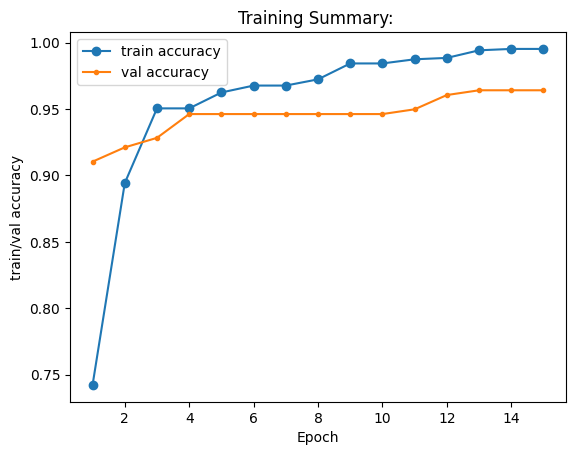

In [ ]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
x1 = epoch
x2 = epoch
y1 = train_acc
y2 = val_acc

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ')
plt.ylabel('train/val accuracy')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val accuracy')

plt.legend(["train accuracy","val accuracy"])
plt.show()

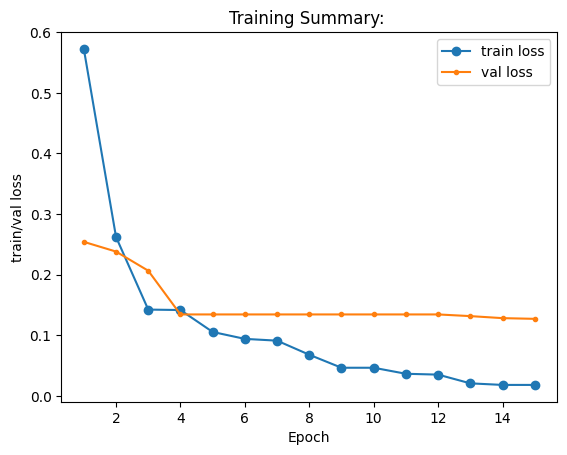

In [ ]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
y1 = train_loss
y2 = val_loss

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ')
plt.ylabel('train/val loss')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val loss')

plt.legend(["train loss","val loss"])
plt.show()


In [ ]:
# INSPECT the retrained Resnet-18 model neural network architecture
# -----------------------------------------------------------------
model_arch = model_hybrid.eval()

message = "[The modified neural network architecture]\n" + str(model_arch)
print(message)

[The modified neural network architecture]
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
 

In [ ]:
def visualize_model(model, num_images=4, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name, figsize=(15,15))
    model.eval()
    with torch.no_grad(): # inferencing
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # Expectation value is probabilistic expected value of the result (measurement) of an experiment
            # Pennylane implements the quantum measurement in such a way that:
            #  - if the first qubit is non zero, it puts negative to the measurement
            # expvals is expectation value of predicted class
            expvals, preds = torch.max(outputs, 1)
            # expvals_min is expectation value of another class as we only have 2 image classes/categories here
            expvals_min, preds_min = torch.min(outputs, 1)
            #print("input size:", type(inputs), inputs.size())
            #print("expvals max", expvals, "\npreds max", preds, "\nexpvals min", expvals_min, "\npreds min", preds_min)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                #title = "Detected as <" + class_names[preds[j]] + ">, Expectation Value: " + \
                #    "{:.5f}".format(expvals[j]) + " (" + \
                #   "{:.5f}".format(expvals_min[j]) + ")"
                title = "Detected as <" + class_names[preds[j]] + ">, Actual was < " + class_names[labels[j]] + ">"
                ax.set_title("[{}]".format(title))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

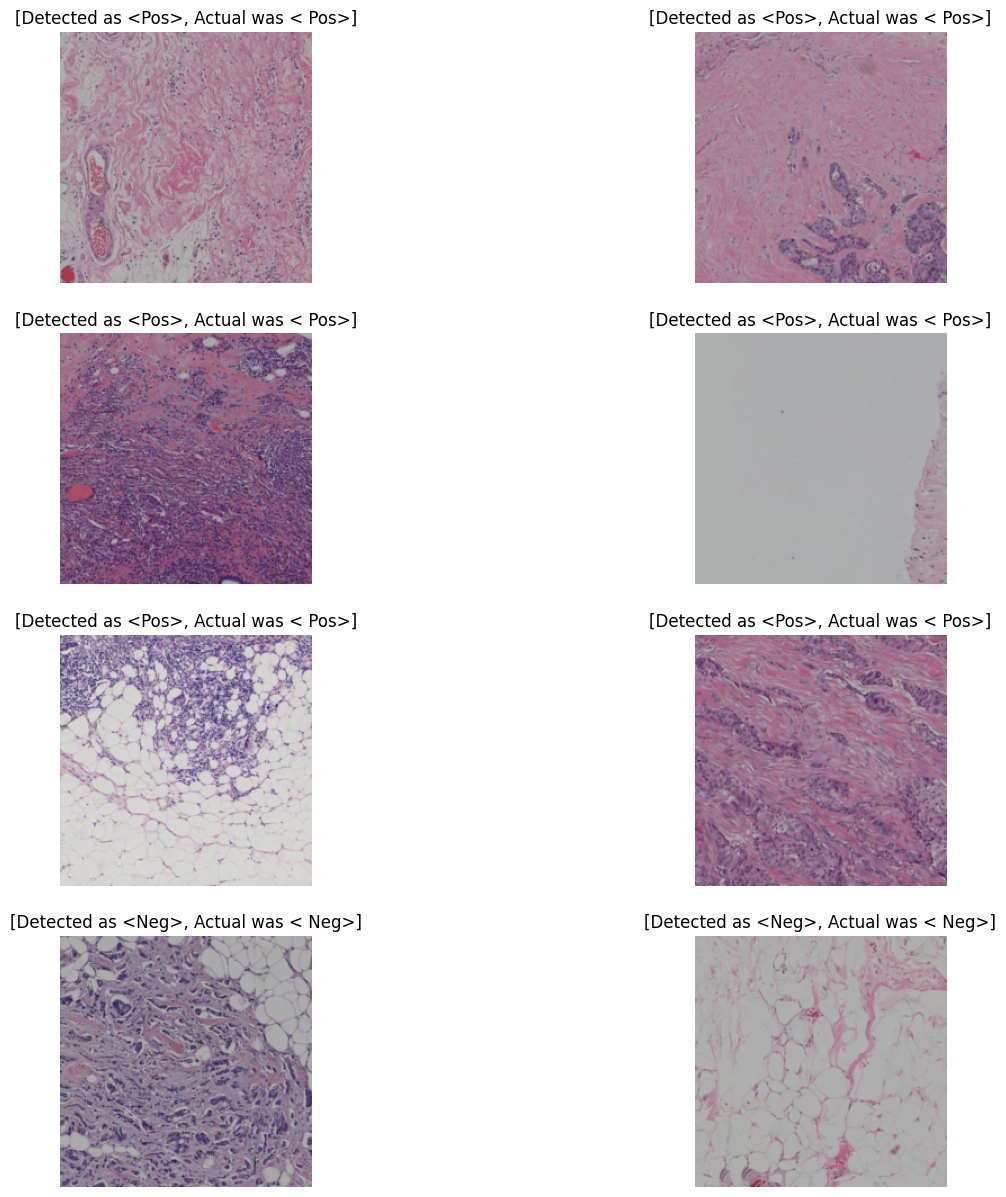

In [ ]:
visualize_model(model_hybrid, num_images=8)
plt.show()